In [1]:
"""
Hamiltonian-Simulation Benchmark Program - Qiskit
"""

import json
import os
import sys
import time

import numpy as np

from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister

sys.path[1:1] = ["_common", "_common/qiskit"]
sys.path[1:1] = ["../../_common", "../../_common/qiskit"]
import execute as ex
import metrics as metrics

# Benchmark Name
benchmark_name = "Hamiltonian Simulation"

np.random.seed(0)

verbose = False

# saved circuits and subcircuits for display
QC_ = None
XX_ = None
YY_ = None
ZZ_ = None
XXYYZZ_ = None

# for validating the implementation of XXYYZZ operation
_use_XX_YY_ZZ_gates = False

# import precalculated data to compare against
filename = os.path.join(os.path.pardir, "_common", "precalculated_data.json")
with open(filename, 'r') as file:
    data = file.read()
precalculated_data = json.loads(data)

In [2]:

############### Circuit Definition

def HamiltonianSimulation(n_spins, K, t, w, h_x, h_z):
    '''
    Construct a Qiskit circuit for Hamiltonian Simulation
    :param n_spins:The number of spins to simulate
    :param K: The Trotterization order
    :param t: duration of simulation
    :return: return a Qiskit circuit for this Hamiltonian
    '''
    
    num_qubits = n_spins
    secret_int = f"{K}-{t}"
    
    # allocate qubits
    qr = QuantumRegister(n_spins); cr = ClassicalRegister(n_spins);
    qc = QuantumCircuit(qr, cr, name=f"hamsim-{num_qubits}-{secret_int}")
    tau = t / K

    # start with initial state of 1010101...
    for k in range(0, n_spins, 2):
        qc.x(qr[k])
    qc.barrier()

    # loop over each trotter step, adding gates to the circuit defining the hamiltonian
    for k in range(K):
    
        # the Pauli spin vector product
        [qc.rx(2 * tau * w * h_x[i], qr[i]) for i in range(n_spins)]
        [qc.rz(2 * tau * w * h_z[i], qr[i]) for i in range(n_spins)]
        qc.barrier()
        
        # Basic implementation of exp(i * t * (XX + YY + ZZ))
        if _use_XX_YY_ZZ_gates:

            # XX operator on each pair of qubits in linear chain
            for j in range(2):
                for i in range(j%2, n_spins - 1, 2):
                    qc.append(xx_gate(tau).to_instruction(), [qr[i], qr[(i + 1) % n_spins]])

            # YY operator on each pair of qubits in linear chain
            for j in range(2):
                for i in range(j%2, n_spins - 1, 2):
                    qc.append(yy_gate(tau).to_instruction(), [qr[i], qr[(i + 1) % n_spins]])

            # ZZ operation on each pair of qubits in linear chain
            for j in range(2):
                for i in range(j%2, n_spins - 1, 2):
                    qc.append(zz_gate(tau).to_instruction(), [qr[i], qr[(i + 1) % n_spins]])

        # Use an optimal XXYYZZ combined operator
        # See equation 1 and Figure 6 in https://arxiv.org/pdf/quant-ph/0308006.pdf
        else:

            # optimized XX + YY + ZZ operator on each pair of qubits in linear chain
            for j in range(2):
                for i in range(j % 2, n_spins - 1, 2):
                    qc.append(xxyyzz_opt_gate(tau).to_instruction(), [qr[i], qr[(i + 1) % n_spins]])

        qc.barrier()

    # measure all the qubits used in the circuit
    for i_qubit in range(n_spins):
        qc.measure(qr[i_qubit], cr[i_qubit])

    # save smaller circuit example for display
    global QC_    
    if QC_ == None or n_spins <= 6:
        if n_spins < 9: QC_ = qc

    return qc

In [3]:
############### XX, YY, ZZ Gate Implementations

# Simple XX gate on q0 and q1 with angle 'tau'
def xx_gate(tau):
    qr = QuantumRegister(2); qc = QuantumCircuit(qr, name="xx_gate")
    qc.h(qr[0])
    qc.h(qr[1])
    qc.cx(qr[0], qr[1])
    qc.rz(3.1416*tau, qr[1])
    qc.cx(qr[0], qr[1])
    qc.h(qr[0])
    qc.h(qr[1])
    
    # save circuit example for display
    global XX_    
    XX_ = qc
    
    return qc

# Simple YY gate on q0 and q1 with angle 'tau'    
def yy_gate(tau):
    qr = QuantumRegister(2); qc = QuantumCircuit(qr, name="yy_gate")
    qc.s(qr[0])
    qc.s(qr[1])
    qc.h(qr[0])
    qc.h(qr[1])
    qc.cx(qr[0], qr[1])
    qc.rz(3.1416*tau, qr[1])
    qc.cx(qr[0], qr[1])
    qc.h(qr[0])
    qc.h(qr[1])
    qc.sdg(qr[0])
    qc.sdg(qr[1])

    # save circuit example for display
    global YY_    
    YY_ = qc

    return qc

# Simple ZZ gate on q0 and q1 with angle 'tau'
def zz_gate(tau):
    qr = QuantumRegister(2); qc = QuantumCircuit(qr, name="zz_gate")
    qc.cx(qr[0], qr[1])
    qc.rz(3.1416*tau, qr[1])
    qc.cx(qr[0], qr[1])

    # save circuit example for display
    global ZZ_    
    ZZ_ = qc

    return qc

# Optimal combined XXYYZZ gate (with double coupling) on q0 and q1 with angle 'tau'
def xxyyzz_opt_gate(tau):
    alpha = tau; beta = tau; gamma = tau
    qr = QuantumRegister(2); qc = QuantumCircuit(qr, name="xxyyzz_opt")
    qc.rz(3.1416/2, qr[1])
    qc.cx(qr[1], qr[0])
    qc.rz(3.1416*gamma - 3.1416/2, qr[0])
    qc.ry(3.1416/2 - 3.1416*alpha, qr[1])
    qc.cx(qr[0], qr[1])
    qc.ry(3.1416*beta - 3.1416/2, qr[1])
    qc.cx(qr[1], qr[0])
    qc.rz(-3.1416/2, qr[0])

    # save circuit example for display
    global XXYYZZ_    
    XXYYZZ_ = qc

    return qc


In [4]:
############### Result Data Analysis

# Analyze and print measured results
# Compute the quality of the result based on operator expectation for each state
def analyze_and_print_result(qc, result, num_qubits, type, num_shots):

    counts = result.get_counts(qc)
    if verbose: print(f"For type {type} measured: {counts}")

    # we have precalculated the correct distribution that a perfect quantum computer will return
    # it is stored in the json file we import at the top of the code
    correct_dist = precalculated_data[f"Qubits - {num_qubits}"]
    if verbose: print(f"Correct dist: {correct_dist}")

    # use our polarization fidelity rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist)

    return counts, fidelity


Hamiltonian Simulation Benchmark Program - Qiskit
... execution starting at Jul 22, 2024 06:09:37 UTC
************
Executing [3] circuits with num_qubits = 2
************
Executing [3] circuits with num_qubits = 3
************
Average Circuit Algorithmic Depth, ξ (xi) for the 2 qubit group = 29, 0.243
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 2 qubit group = 29, 0.243, 9.0
Average Creation, Elapsed, Execution Time for the 2 qubit group = 0.002, 0.686, 0.07 secs
Average Transpiling, Validating, Running Times for group 2 = 0.001, 0.001, 0.001 secs
Average Hellinger, Normalized Fidelity for the 2 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 4
************
Average Circuit Algorithmic Depth, ξ (xi) for the 3 qubit group = 44, 0.265
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 3 qubit group = 44, 0.265, 18.0
Average Creation, Elapsed, Execution Time for the 3 qubit group = 0.02, 1.079, 0.044 secs
Average Transpiling, Valid

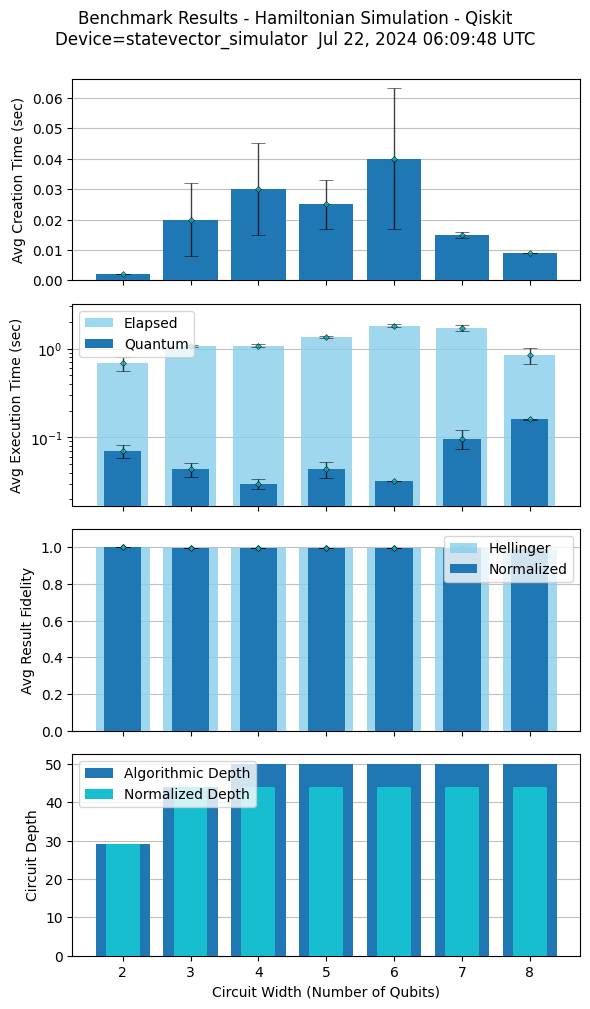

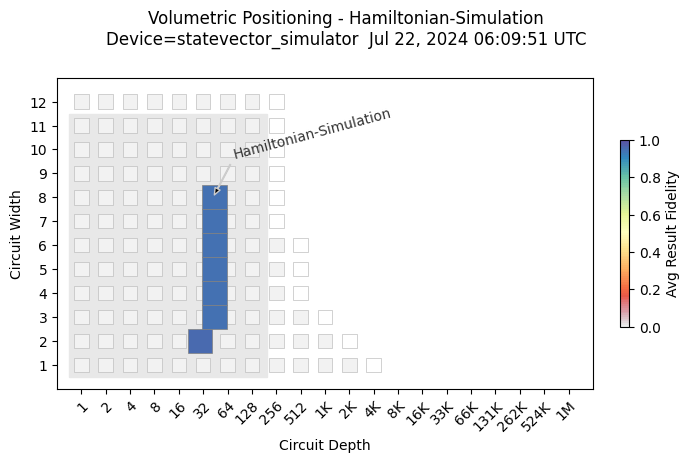

In [5]:

################ Benchmark Loop

# Execute program with default parameters
def run(min_qubits=2, max_qubits=8, max_circuits=3, skip_qubits=1, num_shots=1000,
        use_XX_YY_ZZ_gates = False,
        backend_id='statevector_simulator', provider_backend=None,
        hub="ibm-q", group="open", project="main", exec_options=None,
        context=None):

    print(f"{benchmark_name} Benchmark Program - Qiskit")
    
    # validate parameters (smallest circuit is 2 qubits)
    max_qubits = max(2, max_qubits)
    min_qubits = min(max(2, min_qubits), max_qubits)
    if min_qubits % 2 == 1: min_qubits += 1   # min_qubits must be even
    skip_qubits = max(1, skip_qubits)
    #print(f"min, max qubits = {min_qubits} {max_qubits}")

    # create context identifier
    #if context is None: context = f"{benchmark_name} ({method}) Benchmark"
    if context is None: context = f"{benchmark_name} Benchmark"
    
    # set the flag to use an XX YY ZZ shim if given
    global _use_XX_YY_ZZ_gates
    _use_XX_YY_ZZ_gates = use_XX_YY_ZZ_gates
    if _use_XX_YY_ZZ_gates:
        print("... using unoptimized XX YY ZZ gates")
    
    ##########
    
    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler(qc, result, num_qubits, type, num_shots):
        # determine fidelity of result set
        num_qubits = int(num_qubits)
        counts, expectation_a = analyze_and_print_result(qc, result, num_qubits, type, num_shots)
        metrics.store_metric(num_qubits, type, 'fidelity', expectation_a)

    # Initialize execution module using the execution result handler above and specified backend_id
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id, provider_backend=provider_backend,
            hub=hub, group=group, project=project, exec_options=exec_options,
            context=context)

    ##########
    
    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1, skip_qubits):

        # reset random seed
        np.random.seed(0)

        # determine number of circuits to execute for this group
        num_circuits = max(1, max_circuits)
        
        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")

        # parameters of simulation
        #### CANNOT BE MODIFIED W/O ALSO MODIFYING PRECALCULATED DATA #########
        w = precalculated_data['w']  # strength of disorder
        k = precalculated_data['k']  # Trotter error.
               # A large Trotter order approximates the Hamiltonian evolution better.
               # But a large Trotter order also means the circuit is deeper.
               # For ideal or noise-less quantum circuits, k >> 1 gives perfect hamiltonian simulation.
        t = precalculated_data['t']  # time of simulation
        #######################################################################

        # loop over only 1 circuit
        for circuit_id in range(num_circuits):
        
            #print(circuit_id)
        
            # create the circuit for given qubit size and simulation parameters, store time metric
            ts = time.time()
            h_x = precalculated_data['h_x'][:num_qubits] # precalculated random numbers between [-1, 1]
            h_z = precalculated_data['h_z'][:num_qubits]
            qc = HamiltonianSimulation(num_qubits, K=k, t=t, w=w, h_x= h_x, h_z=h_z)
            metrics.store_metric(num_qubits, circuit_id, 'create_time', time.time() - ts)
            
            # collapse the sub-circuits used in this benchmark (for qiskit)
            qc2 = qc.decompose()
            
            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc2, num_qubits, circuit_id, num_shots)
        
        # Wait for some active circuits to complete; report metrics when groups complete
        ex.throttle_execution(metrics.finalize_group)
    
    # Wait for all active circuits to complete; report metrics when groups complete
    ex.finalize_execution(metrics.finalize_group)

    ##########
    
    # print a sample circuit
    # print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
   
    if _use_XX_YY_ZZ_gates:
        print("\nXX, YY, ZZ =")
        print(XX_); print(YY_); print(ZZ_)
    else:
        print("\nXXYYZZ_opt =")
        print(XXYYZZ_)
        
    # Plot metrics for all circuit sizes
    metrics.plot_metrics(f"Benchmark Results - {benchmark_name} - Qiskit")


# if main, execute method
if __name__ == '__main__': run()
